In [2]:
### RUN THIS CELL (0 Lines) ###
# Loading necessary packages
import nbimporter
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import pandas as pd
import math

from scipy.linalg import eigh, cholesky
from scipy.stats import norm
from pylab import plot, show, axis, subplot, xlabel, ylabel, grid

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
### RUN THIS CELL (0 Lines) ###

In [3]:
### RUN THIS CELL (0 Lines) ###
# Helper Methods 

# getOnehottedDataset - takes a dataframe, a set of features, and prefix names for those features, and one-hots those features.
# Note: ENSURE that the features passed in are discrete/not continuous. 
# @params: 
#    - dataset is a dataframe of individuals you seek to onehot the features of
#    - features is an array of features in the dataset you wish to one-hot
#    - prefixes is an array of names that will be the prefixes of the new columns produced via the one-hot function
# @return: 
#    - returns the dataset with the features, one-hotted.
def getOnehottedDataset(dataset, features, prefixes):
# race, sex, sports, birth origin, education, educational prestige, criminal record, arrest record,
    onehotted_data = dataset.copy()
    onehotted_data = pd.get_dummies(onehotted_data, columns=features, prefix=prefixes)
    return onehotted_data

# graphSelectionRates - outputs a bar graph of the selection rates for each protectedClass, depending on the protected
# class you pass in (race or gender). 
# @params: 
#    - selected is a dataframe of all of the candidates that were chosen by the algorithm
#    - candidates is a dataframe containing all candidates
#    - protectedClass is a flag passed in as either "race" or "gender" depending on what the selection rates you'd like
# @return: 
#    - prints selection rates and a bar graph.
def graphSelectionRates(selected, candidates, protectedClass):
    selected_candidates = selected.copy()
    candidates_all = candidates.copy()
    raceIndxs = {"Caucasian": 0, "African-American": 1, "Asian": 2, "Hispanic": 3, "Other": 4 }
    sexIndxs = {"Male":0, "Female":1}
    
    if protectedClass == "race":
        features = [col for col in selected_candidates if col.startswith("race_")]
        race_selected = selected_candidates[features].idxmax(axis=1).str.replace('race_', '')
        race_all = candidates_all[features].idxmax(axis=1).str.replace('race_', '')
        
        candidates_all["Race"] = race_all
        selected_candidates["Race"] = race_selected

        numCandidates = candidates_all["Race"].value_counts()
        numQualified = selected_candidates["Race"].value_counts()
        
        keys = numQualified.keys()
        
        raceToVal = {
            "Caucasian": 0,
            "Asian": 0,
            "African-American": 0,
            "Hispanic": 0,
            "Other": 0
        }
        
        for key in keys:
            raceToVal[key] = numQualified[key]
            
        selectionRate1 = raceToVal["Caucasian"] / numCandidates["Caucasian"]
        selectionRate2 = raceToVal["Asian"] / numCandidates["Asian"]
        selectionRate3 = raceToVal["African-American"] / numCandidates["African-American"]
        selectionRate4 = raceToVal["Hispanic"] / numCandidates["Hispanic"]
        
        print("The selection rate for " + "Caucasian" + "s: ",selectionRate1)
        print("The selection rate for " + "Asian" + "s: ", selectionRate2)
        print("The selection rate for " + "African-American" + "s: ",selectionRate3)
        print("The selection rate for " + "Hispanic" + "s: ",selectionRate4)
        
        y_pos = np.arange(4)
        performance = [selectionRate1, selectionRate2, selectionRate3, selectionRate4]
        plt.bar(y_pos, performance, align='center', alpha=0.5)
        plt.xticks(y_pos, ("Caucasian", "Asian", "African-American", "Hispanic"))
        plt.ylabel('Selection Rate')
        plt.title('Selection Rate Comparisons by Race')
        plt.show()
    elif protectedClass == "gender":
        features = [col for col in selected_candidates if col.startswith("gender_")]
        gender_selected = selected_candidates[features].idxmax(axis=1).str.replace('gender_', '')
        gender_all = candidates_all[features].idxmax(axis=1).str.replace('gender_', '')

        candidates_all["Gender"] = gender_all
        selected_candidates["Gender"] = gender_selected
        
        numCandidates = candidates_all["Gender"].value_counts()
        numQualified = selected_candidates["Gender"].value_counts()
        
        print(numCandidates)
        print(numQualified) 
        
        maleSelectionRate = numQualified["male"] / numCandidates["male"]
        femaleSelectionRate = numQualified["female"] / numCandidates["female"]
        print("The selection rate for " + "Male" + "s: ", maleSelectionRate)
        print("The selection rate for " + "Female" + "s: ", femaleSelectionRate)
        y_pos = np.arange(2)
        performance = [maleSelectionRate, femaleSelectionRate]
        plt.bar(y_pos, performance, align='center', alpha=0.5)
        plt.xticks(y_pos, ("Male", "Female"))
        plt.ylabel('Selection Rate')
        plt.title('Selection Rate Comparisons by Sex')
        plt.show()
    else:
        print("Try another protected type - gender or race")
        
# transformDatapointsToScale - normalizes the features in the dataset matching with features passed in via selectedFeatures.
# This is done by dividing each of the chosen columns by that columns' max.
# @params:
#    - dataset is a dataframe containing individuals (employees or candidates)
#    - selectedFeatures is an array of strings, where each string is a feature in the df we seek to normalize
# @returns:
#    - the dataframe w. selectedFeature's normalized.
def transformDatapointsToScale(candidates, selectedFeatures):
    df = candidates.copy()
    for feature in selectedFeatures:
        maximum = df[feature].max()
        df[feature] = df[feature].apply(lambda x: x / maximum)
    return df
### RUN THIS CELL (0 Lines) ###

# Milestone 2
## Exercise 1: Deepening our Approach

In the last milestone, your team was working through basic automated algorithms that Sprawlmart had worked with, but the techniques were too naive! In the ranking model, your team came up with weights.  And in your exposure to the nearest neighbor model, you quickly realized that problems with classification arise. So how do we "robustify" our automated approach?

One starting point is more data on past employees. You might think that 2000 employees is simply not enough. To your surprise, a bunch of Sprawlmart data scientists over in engineering, have been working tirelessly to clean a larger dataset and recently sent you a datapoints on 10000 employees that you'll be able to use to help train your models! Maybe that'll help us out.

### Task 1: Familiarizing ourselves with the massive dataset. 
Load the large dataset below!

In [4]:
# RUN THIS CELL (0 Lines) #
employees = pd.read_csv("../Employees_M2/employees_milestone2.csv")
candidates = pd.read_csv("../Candidates_M2/candidates_milestone2.csv")
print(employees.info())
print(candidates.info())
# RUN THIS CELL #

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Names                         10000 non-null  object 
 1   Race                          10000 non-null  object 
 2   Gender                        10000 non-null  object 
 3   Sports                        10000 non-null  float64
 4   Birth Origin                  10000 non-null  object 
 5   Age                           10000 non-null  float64
 6   Zip                           10000 non-null  int64  
 7   Education                     10000 non-null  int64  
 8   GPA                           10000 non-null  float64
 9   Educational Prestige          10000 non-null  float64
 10  Years of Experience           10000 non-null  float64
 11  Soft Skills                   10000 non-null  float64
 12  Manager's Assessment Score    10000 non-null  float64
 13  Mi

#### Subtask 0: Take some time to use the tools below to begin understanding the nuance of this massive dataset. 

As an overview, the features of this big dataset are the same as the smaller sample of 2000 employees that you saw in the last milestone. Recall that we have a bunch of datapoints gathered on each employee including protected characteristics, and then we have some performance metrics of these employees.  The goal is to try and build a model which given the features can effectively predict these metrics.  

##### The cell below takes a categorical feature like "Arrest Record" and displays how that distributes across a selected protected class like race. Just insert the categorical feature and attribute you want to examine.

In [5]:
### RUN THIS CELL (2 Lines) ###

# displayDistributionOfFeature - A function which prints out the distribution of values for a given feature in a dataset
# per ethnicity. This enables us to analyze whether certain ethnicities tend to get classified as having certain feature 
# values more than others or if the general distribution of values for the features is different for different races.
# @params:
#   - dataset is a dataframe of individuals
#   - feature is the feature whose distribution we want to see, NOTE: feature should be categorical not continuous!!!
#   - protectedAttribute is a flag - either "Race" or "Gender"
# @returns:
#   - Just prints the distribution
def displayDistributionOfFeature(dataset, feature, protectedAttribute):
    validAttributes = ["Race", "Sex", "Age", "Birth Origin"]
    if protectedAttribute not in validAttributes:
        print("Protected Attribute not valid")
        return
    groups = dataset.groupby([feature, protectedAttribute])
    print(dataset.groupby([feature, protectedAttribute]).size())
    
# INSERT CODE (2 Lines) #    
feature = "Criminal Record" # INSERT A FEATURE - GPA, Cultural Fit, etc. #
protectedAttribute = "Race" # INSERT A protected class - race, gender, etc. #
# INSERT CODE (2 Lines) #    

print("This is the distribution of values for the 10000 employees for the feature:", feature)
displayDistributionOfFeature(employees, feature, protectedAttribute)
### RUN THIS CELL (2 Lines) ###

This is the distribution of values for the 10000 employees for the feature: Criminal Record
Criminal Record  Race            
0.0              African-American    1260
                 Asian               1350
                 Caucasian           4950
                 Hispanic             900
                 Other                540
1.0              African-American     140
                 Asian                150
                 Caucasian            550
                 Hispanic             100
                 Other                 60
dtype: int64


##### The cell below enables you to scatterplot a feature against a particular metric to see the general relationship between a datapoint and  metrics of performance for the employee. And each point is colored by its specific protected group. 

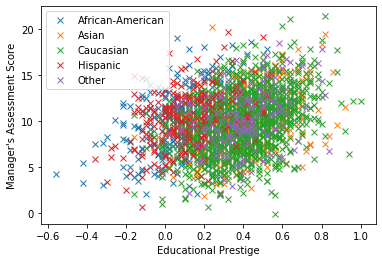

In [6]:
### RUN THIS CELL (4 Lines) ###

# plotFeatureToPerformance - is another printing function that enables us to plot a feature of the dataset
# against a metric to investigate whether there exists some sort of correlation between the two. Each datapoint is further
# coded by its protectedClass identity.
# @params:
#.   - dataset is a dataframe of individuals
#.   - feature is a feature in the dataframe
#.   - metric is a string of one of the three metrics for evaluation - Job Tenure, Avg Deals Closed, or Manager's Assessment Score
#.   - val is an optional array argument you pass in to just plot one or two values that are in the protectedClass (i.e. "Caucasian", "African-American")
# @returns:
#.   - None just plots it out for you.
def plotFeatureToPerformance(dataset, feature, metric, protectedClass, val=None):
    
    df = dataset.copy()
    if val != None:
        if len(val) == 1:
            df = df.loc[(df[protectedClass] == val[0])]
        elif len(val) == 2:
            df = df.loc[(df[protectedClass]== val[0]) | (df[protectedClass]== val[1])]

    df = df[[feature, metric, protectedClass]]

    groups = df.groupby(protectedClass)

    for name, group in groups:
        plt.plot(group[feature], group[metric], marker="x", linestyle="", label=name)
        
    plt.xlabel(feature)
    plt.ylabel(metric)
    plt.legend()
    
feature = "Educational Prestige"# INSERT A FEATURE #
metric = "Manager's Assessment Score"# SELECT A METRIC #
protectedClass =  "Race"# INSERT A PROTECTED CLASS # 
protectedClass_values = "None" # INSERT up to two values of the protected class you chose #
plotFeatureToPerformance(candidates, feature, metric, protectedClass, protectedClass_values)
# plotFeatureToPerformance(candidates, feature, metric, protectedClass) 

### RUN THIS CELL (4 Lines) ###

##### The cell below enables you to choose a protected class, such as race, gender, and find the mean, median, min, and max values per group in that class for a given feature. This should help you see if there's a feature that seems to favor one group in a class over another.

In [7]:
### RUN THIS CELL (2 Line) ###

# printStats - is another printing function that prints out the mean, median, and max values of features
# for a each subgroup of a chosen protected class
# @params:
#.   - dataset is a dataframe of individuals
#.   - feature is a feature in the dataframe
#.   - protectedClass is a flag either "race" or "gender"
# @returns:
#.   - None just prints it out for you.
def printStats(dataset, feature, protectedClass):
    if protectedClass == "race":
        races = ["African-American", "Asian", "Caucasian", "Hispanic", "Other"]
        df = dataset.copy()
        for race in races:
            selectedFeature = df.loc[(df["Race"] == race)][feature]
            print("The mean of " + feature + " for " + race + "s is", selectedFeature.mean())
            print("The median of " + feature + " for " + race + "s is", selectedFeature.median())
            print("The max value of " + feature + " for " + race + "s is", selectedFeature.max())
            print("The min value of " + feature + " for " + race + "s is", selectedFeature.min())
            print("")
    elif protectedClass == "gender":
        genders = ["male", "female"]
        df = dataset.copy()
        for gender in genders:
            selectedFeature = df.loc[(df["Gender"] == gender)][feature]
            print("The mean of " + feature + " for " + gender + "s is", selectedFeature.mean())
            print("The median of " + feature + " for " + gender + "s is", selectedFeature.median())
            print("The max value of " + feature + " for " + gender + "s is", selectedFeature.max())
            print("The min value of " + feature + " for " + gender + "s is", selectedFeature.min())
            print("")
    else:
        print("protectedClass should be 'gender' or 'race'")

feature = "Soft Skills" # Insert feature in the employee dataset #
protectedClass = "race" # Insert gender or race #
printStats(employees, feature, protectedClass)
### RUN THIS CELL (1 Line) ###

The mean of Soft Skills for African-Americans is 2.0534000000000012
The median of Soft Skills for African-Americans is 2.2500000000000004
The max value of Soft Skills for African-Americans is 5.89
The min value of Soft Skills for African-Americans is -2.72

The mean of Soft Skills for Asians is 2.063459999999999
The median of Soft Skills for Asians is 2.34
The max value of Soft Skills for Asians is 5.74
The min value of Soft Skills for Asians is -2.36

The mean of Soft Skills for Caucasians is 2.996414545454544
The median of Soft Skills for Caucasians is 3.0
The max value of Soft Skills for Caucasians is 5.97
The min value of Soft Skills for Caucasians is 0.13

The mean of Soft Skills for Hispanics is 2.0191199999999974
The median of Soft Skills for Hispanics is 2.275
The max value of Soft Skills for Hispanics is 5.37
The min value of Soft Skills for Hispanics is -2.15

The mean of Soft Skills for Others is 3.036816666666669
The median of Soft Skills for Others is 3.03
The max value of

Great, you and your team can continue using the tools above throughout this exercise
and even into the next one to try and understand particular aspects of the dataset. Keep on using the tools to try and find hidden biases within the data, correlations, etc. While these functions are quite simplistic, and data scientists will use algorithms and analytic methods to study their data even further, this is a good start!

##  Task 2: Running a Linear Regression Model. 

Ok, now that your team has built up an intuition for the dataset, the relationship between some features and particular measures of performance, and potential biases, lets go ahead and attempt to deploy a simple model to select candidates as employees.  We'll start with linear regression, which you may already be familiar with.  

Linear Regression is a model that assumes a linear relationship between the input variables (x) and the single output variable and attempts to learn a best fit line which models that relationship.

We'll need to 
* Select our Features, 
* Process the data
* Run the model
* Analyze Performance

In this exercise and the next however, for the sake of saving your team some time, we'll use the features and data processing that the previous Sprawlmart R&D team had already used so your crew can run the model right away and begin analyzing performance. You'll get the chance to build your whole entire model in Exercise 3! 

In [6]:
# RUN THIS CELL (0 Lines) #
# One-hotting the dataset for use
features = ["Race", "Gender", "Birth Origin", "Criminal Record", "Sports",
           "Arrest Record", "LinkedIn Score", "Responsible Social Media Use", "Undergraduate Degree"]
prefixes = ["race", "gender", "origin", "criminal", "sports", "arrest", "linkedin", 
           "socmedia", "degree"]
employees_race = employees["Race"]
candidates_race = candidates["Race"]
employees_processed = getOnehottedDataset(employees, features, prefixes)
employees_processed["Race"] = employees_race
candidates_processed = getOnehottedDataset(candidates, features, prefixes)
candidates_processed["Race"] = candidates_race
# candidates_processed.info()
# RUN THIS CELL #

#### Feature & Metric Selection
It looks like the Sprawlmart engineering team chose Manager's Assessment Score as its metric and 
Soft Skills, Years of Experience, & Educational Prestige as its score.

In [7]:
### Run this Cell (0 Lines) ###
selectedFeatures = [
    "Soft Skills", "Years of Experience", "Educational Prestige"
]

metric = "Manager's Assessment Score" # Training on and thus attempting to learn a regressor
# to predict the Manager's Assessment score.

### Run this Cell (0 Lines) ###

##### Normalize data and split into Train & Test
Typically when we run a model, we want to ensure that its behavior is generalizable to do this invoke a train test split to try and ensure that model is not overfitting to its input. In general, when you're applying ML algorithms out in the wild it is absolutely essential to split your data in a train and test split so you have a semblance of understanding as to whether your model can actually generalize!

- The first cell block splits our dataset into a train-test (75/25) split.

In [10]:
# RUN THIS CELL (0 Lines) #
# Currently just a divide by max - normalization scheme...
employees_scaled = transformDatapointsToScale(employees_processed, selectedFeatures)
candidates_scaled = transformDatapointsToScale(candidates_processed, selectedFeatures)

y = employees_scaled[metric]
X = employees_scaled.drop([metric], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)

X_train_selectedFeatures = X_train[selectedFeatures].copy()
X_test_selectedFeatures = X_test[selectedFeatures].copy()
# RUN THIS CELL #

#### Subtask: 
##### Model Training

In [11]:
# RUN THIS CELL (0 Lines) #
model = LinearRegression()
trained_model = model.fit(X_train_selectedFeatures, y_train) # Training or fitting the model.
# RUN THIS CELL #

/Users/jonahwu/miniconda3/envs/cs231n/lib/python3.7/site-packages/sklearn/linear_model/_base.py:533: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


##### Initial Results

We'll be using two metrics to try and gauge the model's performance in accurately predicting the Manager's Assessment Score. The first is Mean Squared Error or MSE, and the second is the R^2 score.  

R^2 is the proportion of the variance in the dependent variable that is predictable from the independent variable.
Mean Squared Error measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. 

But more simply, R^2 tells you the strength of correlation. Mean Squared Error, tells you how "off" your predictions were cumulatively compared to the real scores. R^2 of 1 is perfect, 0 totally anti-correlated. Mean Squared Error of 0 means you predicted every score perfectly.

In [12]:
# RUN THIS CELL (0 Lines) #

# printRegressionStats - a function printing the MSE and r2 score based on the predictions and ground truth value
#.  @params
#.    - y_true: array of the ground truth values
#.    - y_pred: array of the predicted values
#.  @returns
#.    - None simply prints out stats
def printRegressionStats(y_true, y_pred):
    print("MSE value is", mean_squared_error(y_true, y_pred))
    print("R^2 value is", r2_score(y_true, y_pred))

# Let's analyze the results ==>
y_pred = trained_model.predict(X_train_selectedFeatures)
print("The results on the training set")
printRegressionStats(y_train, y_pred)
print("")
print("The results on the test set")
y_test_pred = trained_model.predict(X_test_selectedFeatures)
printRegressionStats(y_test, y_test_pred)
y_test_pred

# RUN THIS CELL (0 Lines) #

The results on the training set
MSE value is 4.318832868472987
R^2 value is 0.5691403671204136

The results on the test set
MSE value is 4.069773943150768
R^2 value is 0.6110941011045325


array([11.56930919,  8.21765919,  7.63250191, ..., 13.34457366,
       12.35810334, 12.59800586])

##### Ranking results and selecting candidates
Ok, not too good at all! Let's follow through though with the results. Recall that our trained 
regression model here now predicts the manager's assessment score of an individual based on weights it has 
trained for educational prestige, years of experience, and soft skills.

So now we'll use our trained model to predict the manager's assessment scores of these next 2500 candidates that have applied for the Sales Associate Position. We'll then select the top 10% of candidate to move onto the next round.

In [13]:
# RUN THIS CELL (0 Lines) #

# rankJobCandidates - sorts a dataframe by the "Score" feature - NOTE: assumes that candidate df has "Score"
#  @params:
#    - candidates is a dataframe containing candidates
#  @returns:
#    - df containing candidates but sorted by descending Scores
def rankJobCandidates(candidates):
    candidates = candidates.copy()
    candidates = candidates.sort_values(["Scores"], ascending=False)
    return candidates

# selectCandidates - Takes in the candidate dataset and returns the top percentile. 
# @params:
#   - candidates is a dataframe containing candidates
#   - top_percent is the top percent scoring individuals we want to "select" as making it to the next stage.
# @returns:
#   - dataframe of candidates in the top_percent
def selectCandidates(candidates, percentile):
    numCandidates = math.floor(len(candidates) * percentile)
    return candidates.iloc[:numCandidates]

percentile = .10 # Selecting the top 10 percent scoring candidates based on our regression model. 
candidate_data = candidates_scaled[selectedFeatures].copy()
candidate_pred = trained_model.predict(candidate_data)
candidates_scaled["Scores"] = candidate_pred
candidates_ranked = rankJobCandidates(candidates_scaled)
candidatesSelected = selectCandidates(candidates_ranked, percentile)
candidatesSelected

# RUN THIS CELL (0 Lines) #

Names   Age    Zip  Education   GPA  Educational Prestige  \
2057      Larry Brown  38.0  94087          5  3.25                  0.46   
1297      Frank Stone  42.0  94603          5  3.64                  0.50   
1092       Amy Martin  38.0  95002          5  3.73                  0.46   
676     Jerry Sonoski  38.0  94040          5  4.54                  0.60   
943      Walter Davis  29.0  94611          5  4.19                  0.74   
...               ...   ...    ...        ...   ...                   ...   
1635  Richard Leasure  33.0  94304          2  3.11                  0.38   
1328    Thomas Tucker  42.0  94043          4  4.44                  0.28   
404    Judith Simpson  36.0  94131          5  3.36                  0.40   
1164    Paris Chittum  38.0  94030          5  2.40                  0.32   
758    George Woodman  35.0  94539          4  2.88                  0.00   

      Years of Experience  Soft Skills  Manager's Assessment Score  \
2057             1.000000     0.790244                       18.25   
1297             0.888889     0.816260                       17.29   
1092             0.888889     0.808130                       16.10   
676              0.703704     1.000000                       20.36   
943              0.703704     0.897561                       17.90   
...                   ...          ...                         ...   
1635             0.518519     0.622764                       11.41   
1328             0.407407     0.837398                       16.99   
404              0.555556     0.552846                       12.54   
1164             0.629630     0.466667                       10.05   
758              0.666667     0.534959                       11.64   

      Military Tenure  ...  linkedin_Very Good  socmedia_Bad  socmedia_Good  \
2057              0.0  ...                   1             0              1   
1297              0.0  ...                   1             0              1   
1092              1.5  ...                   0             0              1   
676               0.0  ...                   0             0              1   
943               1.0  ...                   0             0              1   
...               ...  ...                 ...           ...            ...   
1635              0.0  ...                   0             0              1   
1328              0.0  ...                   1             1              0   
404               0.0  ...                   0             0              1   
1164              0.0  ...                   0             0              1   
758               0.0  ...                   1             0              1   

      degree_Engineering  degree_Humanities  degree_None  degree_Quantitative  \
2057                   0                  0            0                    1   
1297                   0                  0            0                    1   
1092                   0                  1            0                    0   
676                    0                  1            0                    0   
943                    1                  0            0                    0   
...                  ...                ...          ...                  ...   
1635                   1                  0            0                    0   
1328                   1                  0            0                    0   
404                    0                  1            0                    0   
1164                   0                  1            0                    0   
758                    1                  0            0                    0   

      degree_Sciences              Race     Scores  
2057                0         Caucasian  18.883387  
1297                0         Caucasian  18.128526  
1092                0         Caucasian  17.993855  
676                 0         Caucasian  17.730214  
943                 0         Caucasian  17.469164  
...       

Race
African-American     26
Asian                36
Caucasian           153
Hispanic             15
Other                20
dtype: int64
The selection rate for Caucasians:  0.11127272727272727
The selection rate for Asians:  0.096
The selection rate for African-Americans:  0.07428571428571429
The selection rate for Hispanics:  0.06


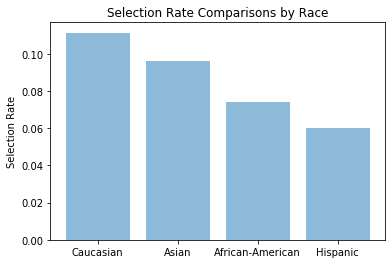

In [14]:
### RUN THIS CELL (1 Line) ###
print(candidatesSelected.groupby(["Race"]).size())
graphSelectionRates(candidatesSelected, candidates_scaled, "race")
### RUN THIS CELL (1 Line) ###

### Questions: 
- Report the selection rates
- Analyze the data and model more closely, why does your team think there is a disparity in the selection rates?

## Task 3: Differential Validity 

Ok in the previous milestone we tried to investigate the problem of differential validity through considering how certain skews in the data might make it such that our design of the model's weights could be helpful for one group of individuals but not another.  

Now that we've trained a model, we can actually investigate the learned weights for the selected features and consider differential validity problems more concretely. 

As of now, recall that the highest (10%) scoring candidates will get selected, and that the scores are calculated by multiplying the learned weights of each selected feature with the candidate's feature values and adding them up. So positive weights indicate a positive relation with the resulting score and negative weights indicate a negative relation. 

Take a look at the learned weights of the model using the features and metric you chose by running the cell below.

In [15]:
# RUN THIS CELL (1 Line) #

# Checking the weights
coeff_values = list(model.coef_)
featureToValues = {selectedFeatures[x] : coeff_values[x] for x in range(len(selectedFeatures))}
print("These are the weights attached to the datapoints of the selected features for each of the candidates to predict the", metric)
print(featureToValues)

# RUN THIS CELL #

These are the weights attached to the datapoints of the selected features for each of the candidates to predict the Manager's Assessment Score
{'Soft Skills': 5.595347457900792, 'Years of Experience': 8.906504083946885, 'Educational Prestige': 2.229516845088589}


### Questions:
- By analyzing the model weights, how can you examine whether your model exhibits a potential differential validity problem? 
- Run the model on different sets of features and performance metrics, by analyzing the weights and using the tools in task 1, can you find a differential validity problem in one of those feature/metric combinations in the dataset?
- If so, what are some ways you can address the differential validity?

### Subtask: Tweaking the model (Optional)
 - Feel free to use other features and test model performance using those different features.  Report if you were able to see noticeable gains in improvement or rectifications of bias. 
 - Your team will get a chance to build/tweak a model on Exercise 3 so no need to try and get this model perfect.